In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import random
import yahoofinancials as yf
import datetime
import xmltodict, json, ast

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# TODO: add proxy servers, else, you will get banned by the hosters for scraping

# Known issues for onvista
# - isin/wkn do not work, freetext can be imprecise, need stronger filters

In [2]:
def preprocess_price_targets(data, valid_days=60, roll_days=5):
    """
    Sampling function for the price targets taking the validity
    of the analysts' opinion into account.
    """
    def simple_sampler(datestr, rn, return_str=True):
        if type(datestr) == datetime.date:
            dt = datestr + datetime.timedelta(days=int(rn))
        elif type(datestr) == str:
            dt = datetime.datetime.strptime(datestr, '%Y-%m-%d') + \
                 datetime.timedelta(days=int(rn))
        if return_str:
            return dt.strftime('%Y-%m-%d')
        return dt
    
    results = []
    tmp = data.copy()
    tmp.sort_values(['dates'], inplace=True)
    for analyst in tmp['analyst'].unique():
        x = tmp.loc[tmp['analyst']==analyst, ['dates', 'analyst', 
                                              'price_target']]
        y = tmp.loc[tmp['analyst']==analyst, 'dates'].diff(
        ).dt.days.shift(-1, fill_value=valid_days)
        results.append(pd.concat([x, y], axis=1))
    results = pd.concat(results)
    results.columns = ['dates', 'analyst', 'price_target', 'validity_days']
    results['validity_days'] = results['validity_days'].astype('int')
    results.sort_values(['dates'], inplace=True)
    results = results.loc[results['price_target'].notna(), :]
    
    sampled = []
    for row in range(len(results)):
        np.random.seed(row**2)
        sampled.append(pd.DataFrame([(
            simple_sampler(results['dates'].astype('str').values[row], rn), 
            results['price_target'].iloc[row]) 
                  for rn in range(results['validity_days'].iloc[row])])
        )

    sampled = pd.concat(sampled)
    sampled.columns = ['dates', 'price_target']
    sampled['dates'] = pd.to_datetime(sampled['dates'])
    sampled = sampled.groupby(['dates']).agg({'price_target': 'median'}
                                        ).sort_values(['dates'])
    sampled['rolling_median'] = sampled['price_target'].rolling(roll_days, 
                                            center=True).median()
    sampled['rolling_std'] = sampled['price_target'].rolling(roll_days, 
                                            center=True).std()
    sampled.reset_index(inplace=True)
    return sampled

def load_stock_data(idxs, start='2010-01-01', end='2020-06-01',
                    interval='daily'):
    data = yf.YahooFinancials(idxs)
    data = data.get_historical_price_data(start_date=start, 
                                          end_date=end, 
                                          time_interval=interval)
    df = []
    for col in idxs:
        tmp = pd.DataFrame(data[col]['prices'])
        tmp['stockname'] = col
        try:
            tmp['currency'] = data[col]['currency']
        except:
            tmp['currency'] = ''
        df.append(tmp)
    df = pd.concat(df)
    df['formatted_date'] = pd.to_datetime(df['formatted_date'], 
                                        format='%Y-%m-%d').dt.date
    df.sort_values(['stockname', 'formatted_date'], inplace=True)
    return df

# Requires user input

In [56]:
# For yahoofinancials:
TICKER = 'LHA.DE'
START = '2018-01-01'
END = (datetime.datetime.utcnow() - 
        datetime.timedelta(days=1)).strftime('%Y-%m-%d')

# For Onvista
SEARCHTERM = 'lufthansa' # search keyword, lowercase

# For Handelsblatt
ISIN = 'DE0008232125'

# Price Targets - Onvista

In [68]:
def get_price_target_onvista(searchterm, startdate='01.01.2018',
                              enddate='22.07.2020', proxies={}):
    """
    Function that scraps the price targets for stocks from www.onvista.de
       and returns a dataframe containing the necessary information.
    """
    def interpret_href(text, searchterm):
        try:
            words = ' '.join([words.strip() for words in 
                              ' '.join(text.split('-')[:-1]).replace(' ziel', ''
                                ).replace(' auf', '').replace(' euro', ''
                                ).replace(' wert', '').split(searchterm)])
        except:
            words = ''
        return words
     
    dfs = []
    link = f'https://www.onvista.de/news/feed/rss.xml?orderBy=datetime&' + \
            f'searchTerm={searchterm}&tags[]=Stocks&newsType[]=analysis&' + \
            f'min={startdate}&max={enddate}'

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)' + \
               ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
    page = requests.get(link, headers=headers, proxies=proxies)
    xml = xmltodict.parse(page.text)
    json_data = json.dumps(xml)
    rss_list = ast.literal_eval(json_data)['rss']['channel']['item']
    rss_list = [pd.json_normalize(enum) for enum in rss_list]
    df = pd.concat(rss_list).reset_index(drop=True)
    df = df.loc[:, ['title', 'link', 'description', 'pubDate']]
    
    df['timestamp'] = pd.to_datetime(df['pubDate'], utc=True)
    df['href_last'] = df['link'].apply(lambda x: x.split('/')[-1])
    df['contains_euro'] = df['href_last'].apply(lambda x: 'euro' in x.lower())
    df['contains_dollar'] = df['href_last'].apply(lambda x: 'dollar' in x.lower())
    df['contains_searchterm'] = df['href_last'].apply(lambda x: searchterm in x.lower())
    df['processed_text']= df['href_last'].apply(lambda x: interpret_href(x, searchterm))
    df['price_target'] = df['processed_text'].apply(lambda x: '.'.join(re.findall('\d+', x)))
    df['dates'] = pd.to_datetime(df['timestamp'].dt.date)
    df['analyst'] = df['processed_text'].apply(lambda x: x.split(' ')[0])
    df['price_target'] = pd.to_numeric(df['price_target'].replace('', '-1'), 
                                       errors='coerce', downcast='float')
    df.drop_duplicates(['dates', 'analyst', 'price_target'], inplace=True)
    return df

dates = [('01.01.2018', '01.07.2018'), 
         ('01.07.2018', '01.01.2019'),
         ('01.01.2019', '01.07.2019'), 
         ('01.07.2019', '01.01.2020'),
         ('01.01.2020', '01.07.2020')]

In [69]:
dfs = []
for dstart, dend in dates:
    dfs.append(get_price_target_onvista2(SEARCHTERM, startdate=dstart,
                                            enddate=dend))
download_onvista = pd.concat(dfs).reset_index()

In [72]:
onvista = download_onvista.copy()

# Make a subselect for currency (€ or $)
onvista = onvista.loc[ (onvista['contains_searchterm']==True) &
            (onvista['price_target']>0) &
            (onvista['contains_euro']==True), :]

onvista.head(3)

,index,title,link,description,pubDate,timestamp,href_last,contains_euro,contains_dollar,contains_searchterm,processed_text,price_target,dates,analyst
0,0,ANALYSE-FLASH: Bernstein belässt Lufthansa auf...,https://www.onvista.de/news/analyse-flash-bern...,NEW YORK (dpa-AFX Broker) - Das US-Analysehaus...,"Wed, 27 Jun 2018 08:13:11 +0200",2018-06-27 06:13:11+00:00,analyse-flash-bernstein-belaesst-lufthansa-auf...,True,False,True,analyse flash bernstein belaesst outperform 29,29.0,2018-06-27,analyse
1,1,Bernstein belässt Lufthansa auf 'Outperform' -...,https://www.onvista.de/news/bernstein-belaesst...,NEW YORK (dpa-AFX Analyser) - Das US-Analyseha...,"Wed, 27 Jun 2018 08:05:58 +0200",2018-06-27 06:05:58+00:00,bernstein-belaesst-lufthansa-auf-outperform-zi...,True,False,True,bernstein belaesst outperform 29,29.0,2018-06-27,bernstein
2,2,HSBC senkt Ziel für Lufthansa auf 31 Euro - 'Buy',https://www.onvista.de/news/hsbc-senkt-ziel-fu...,LONDON (dpa-AFX Analyser) - Die britische Inve...,"Fri, 22 Jun 2018 07:46:59 +0200",2018-06-22 05:46:59+00:00,hsbc-senkt-ziel-fuer-lufthansa-auf-31-euro-buy...,True,False,True,hsbc senkt fuer 31 buy,31.0,2018-06-22,hsbc
3,3,ANALYSE-FLASH: SocGen senkt Ziel für Lufthansa...,https://www.onvista.de/news/analyse-flash-socg...,PARIS (dpa-AFX Broker) - Die französische Groß...,"Mon, 18 Jun 2018 08:03:52 +0200",2018-06-18 06:03:52+00:00,analyse-flash-socgen-senkt-ziel-fuer-lufthansa...,True,False,True,analyse flash socgen senkt fuer 28 buy,28.0,2018-06-18,analyse
4,4,SocGen senkt Ziel für Lufthansa auf 28 Euro - ...,https://www.onvista.de/news/socgen-senkt-ziel-...,PARIS (dpa-AFX Analyser) - Die französische Gr...,"Mon, 18 Jun 2018 07:58:26 +0200",2018-06-18 05:58:26+00:00,socgen-senkt-ziel-fuer-lufthansa-auf-28-euro-b...,True,False,True,socgen senkt fuer 28 buy,28.0,2018-06-18,socgen


# Price Targets - Handelsblatt

In [59]:
def get_price_target_hblatt(isin, offsets=(0, 1e3), proxy={}):
    """
    Function that scraps the price targets for stocks 
    from https://finanzen.handelsblatt.com
    and returns a list of dataframes containing 
    the necessary information.
    """
    offset, max_off = offsets
    dfs = []
    while offset < max_off:
        link = f'https://finanzen.handelsblatt.com/analysen_check.htn?' + \
               f'suchbegriff={isin}&suche=1&offset={offset}'
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)' + \
                   ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
        page = requests.get(link, headers=headers, proxies=proxy)
        html = BeautifulSoup(page.text, 'html.parser')
        errors = html.find_all(attrs={'class': 'vhb-headline-wrapper'})[0]
        error_msg = 'Es konnten keine Analysen gefunden werden.'
        if not error_msg in errors.text:
            table = html.find_all(attrs={'class': 'vhb-vwd-analysts-list'})
            subhtml = BeautifulSoup(f'<html><head></head><body>{table[0]}</body></html>', 
                                            'html.parser')

            analysts = subhtml.find_all(attrs={'class': 'vhb-vwd-trigger-link'})
            targets = subhtml.find_all(attrs={'class': 'vhb-vwd-value vhb-vwd-pr'})
            elem = subhtml.find_all(attrs={'class': 'col-md-8'})
            #elem[0]: analyst, price_target
            #elem[1]: date, stock info
            #elem[2]: info

            analysts = [analyst.text for analyst in analysts]
            targets = [el.find_all('dl')[0].text.split('Kursziel')[-1].replace('\n', ''
                ).replace('€', '').replace('$', '').replace('.', ''
                ).replace(',', '.').strip()
                for enum, el in enumerate(elem) if (enum)%3==0]
            dates = [el.find_all(attrs={'class': 'vhb-vwd-value'})[0].text 
              for enum, el in enumerate(elem) if (enum-1)%3 == 0 ]

            df = pd.DataFrame([dates, analysts, targets]).transpose()
            df.columns = ['dates', 'analyst', 'price_target']

            dfs.append(df)
            offset += 7
            time.sleep(np.random.random()*5)
        else:
            print('Finished download of {} pages.'.format(offset//7))
            break
           
    df = pd.concat(dfs)
    df['dates'] = pd.to_datetime(df['dates'], format='%d.%m.%Y')
    df['price_target'] = df['price_target'].apply(lambda x:  
                            pd.to_numeric(x, errors='coerce'))
    df.sort_values(['dates'], inplace=True)
    df.drop_duplicates(inplace=True)
        
    return df

In [60]:
download_hblatt = get_price_target_hblatt(ISIN)

Finished download of 18 pages.


In [61]:
hblatt = download_hblatt.copy()
hblatt = hblatt.loc[hblatt['price_target'].notna(), :].copy()

# Price Target Analysis

In [73]:
stock = load_stock_data([TICKER], START, END)
stock['formatted_date'] = pd.to_datetime(stock['formatted_date'])

onvista_smp = preprocess_price_targets(onvista, 30)
hblatt_smp = preprocess_price_targets(hblatt, 30)

Text(0, 0.5, 'Price Target')

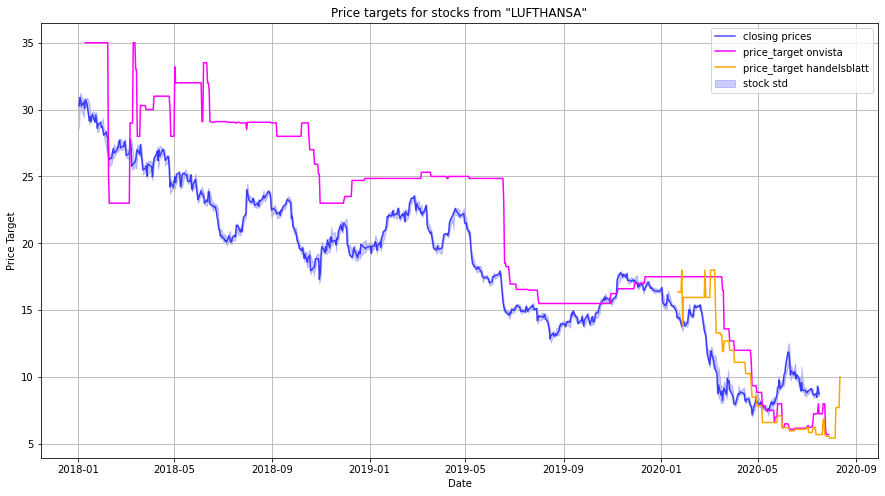

In [74]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.fill_between(stock['formatted_date'], stock['high'],
                stock['low'], color='blue', 
         label='stock std', alpha=0.2)
ax.plot(stock['formatted_date'], stock['close'], color='blue', 
         label='closing prices', alpha=0.7)

ax.plot(onvista_smp['dates'], onvista_smp['price_target'], 
        label='price_target onvista',
        color='magenta')
ax.plot(hblatt_smp['dates'], hblatt_smp['price_target'],
            label='price_target handelsblatt', color='orange')
plt.legend()
plt.grid()
plt.title('Price targets for stocks from "{}"'.format(
    str.upper(SEARCHTERM)))
plt.xlabel('Date')
plt.ylabel('Price Target')

# Residual between real and target price

In [75]:
#TODO: Rolling difference instead of fixed value for all history

residual = pd.merge(onvista_smp, stock, left_on='dates', right_on='formatted_date', how='left')
residual['diff'] = residual.price_target - residual.close
residual['diff'] = residual['diff'].fillna(method='ffill')

(736704.0, 737635.0)

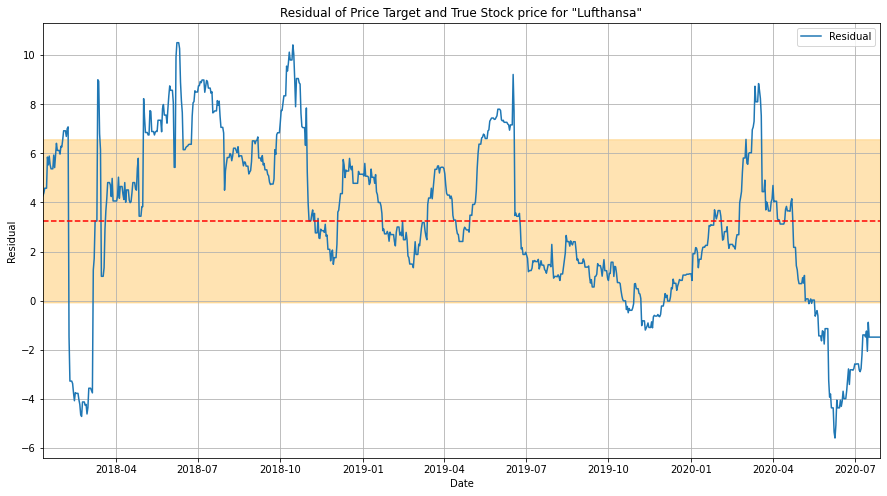

In [76]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(residual['dates'], residual['diff'], label='Residual')
mvalues = np.array([residual['diff'].median()]*len(residual))
svalues = np.array([residual['diff'].std()]*len(residual))
ax.plot(residual['dates'], mvalues, ls='--', color='r')
ax.fill_between(residual['dates'],
                 mvalues + svalues,
                 mvalues - svalues, color='orange', alpha=0.3);
ax.legend()
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.set_title('Residual of Price Target and True Stock price for "{}"'.format(str.capitalize(SEARCHTERM)))
ax.set_xlim([residual['dates'].min(), residual['dates'].max()])

In [79]:
target, target_std = onvista_smp.loc[onvista_smp['rolling_median'].notna(), 
                                     ['rolling_median', 'rolling_std']].tail(1).values[0]
target, target_std

(5.699999809265137, 0.1788854808534246)